In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import sys
import os
import pandas as pd
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

# Add the project root to the system path using the current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import using absolute path from project root
from src.instances.chain_instance import ARBITRUM_DTO, OPTIMISM_DTO, ETHEREUM_DTO, BASE_DTO
from src.instances.aave_instance import AaveArbitrum, AaveOptimism, AaveEthereum, AaveBase
from src.models.token import TokenDTO
from src.models.trade_pair import PairDTO


In [90]:
from src.scripts.process_stored_data_aave import update_trade_pair_exchange_price, \
    create_liquidatable_user_data_series, create_health_ratio_data_emode, create_asset_mapping, \
    create_health_ratio_data, create_liquidatable_user_data, scale_supply_and_create_liquidations, \
    create_liquidations_v2, scale_price_and_identify_liquidatable_collateral


In [91]:
chain_object_mapping = {
    'ethereum': [ETHEREUM_DTO, AaveEthereum],
    'arbitrum': [ARBITRUM_DTO, AaveArbitrum],
    'optimism': [OPTIMISM_DTO, AaveOptimism],
    'base': [BASE_DTO, AaveBase]
}


In [92]:
CHOOSEN_CHAIN = 'ethereum'
AAVE_EMODE_LT = 0.95
ASSET_UNDER_CONSIDERATION = "WETH"

if CHOOSEN_CHAIN not in chain_object_mapping:
    print("Invalid chain chosen.")
    exit(1)
else:
    chain_instance, aave_instance = chain_object_mapping[CHOOSEN_CHAIN]


In [93]:
if not os.path.exists('aave_supported_asset_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_supported_asset_data = aave_instance.get_aave_supported_asset_data()
    print("Saving to file.")
    aave_supported_asset_data.to_csv('aave_supported_asset_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_supported_asset_data = pd.read_csv('aave_supported_asset_data.csv')


File found. Reading from file.


In [94]:
if not os.path.exists('aave_user_position_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_user_position_data = aave_instance.get_user_position_data(aave_supported_asset_data)
    print("Saving to file.")
    aave_user_position_data.to_csv('aave_user_position_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_user_position_data = pd.read_csv('aave_user_position_data.csv')


File found. Reading from file.


In [95]:
aave_asset_object_dict = {}

for _, row in tqdm(aave_supported_asset_data.iterrows(), total=len(aave_supported_asset_data), desc="Creating TokenDTO objects"):
    token = TokenDTO(
        address=row['assetAddress'],
        name=row['symbol'],
        symbol=row['symbol'],
        decimals=row['decimals'],
        chain=chain_instance,
        price=row['price'],
    )
    aave_asset_object_dict[row['symbol']] = token

Creating TokenDTO objects: 100%|██████████| 37/37 [00:10<00:00,  3.45it/s]


In [96]:
current_price_mapping = {}
for index, asset in aave_supported_asset_data.iterrows():
    current_price_mapping[asset['symbol']] = asset['price']

In [97]:
liquidatable_price_df = scale_price_and_identify_liquidatable_collateral(aave_supported_asset_data, 
                                                            aave_user_position_data, 
                                                            current_price_mapping, 
                                                            AAVE_EMODE_LT, 
                                                            ASSET_UNDER_CONSIDERATION,
                                                            0.5, 
                                                            30)



Scaling WETH price: 100%|██████████| 30/30 [03:47<00:00,  7.59s/scale]


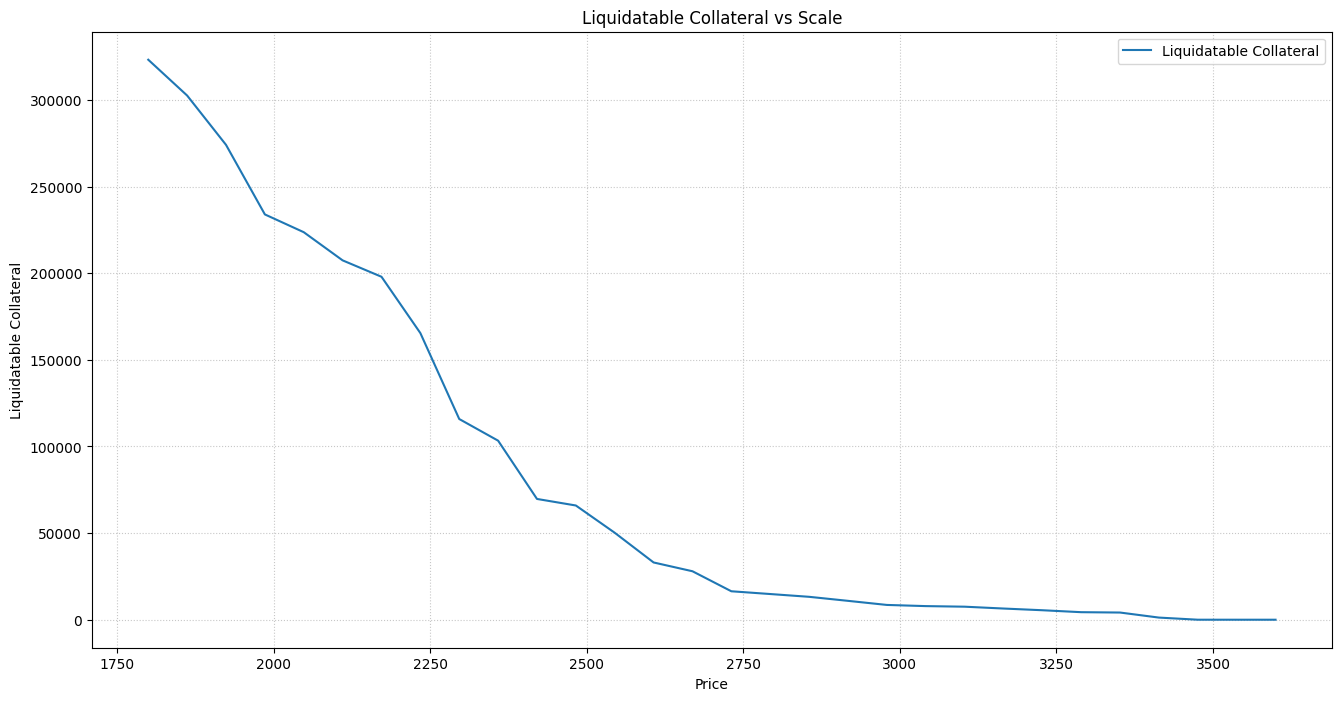

In [98]:
# plot scale and liquidatable_collateral
plt.figure(figsize=(16, 8))
plt.plot(liquidatable_price_df['price'], liquidatable_price_df['liquidatable_collateral'], label='Liquidatable Collateral')
plt.xlabel('Price')
plt.ylabel('Liquidatable Collateral')
plt.title('Liquidatable Collateral vs Scale')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

## Curve user positions

In [99]:
from src.instances.curve_mint_market_instance import market_objects_dict


In [100]:
ASSET_UNDER_CONSIDERATION_CURVE = 'WETH'


In [101]:
market = market_objects_dict[ASSET_UNDER_CONSIDERATION_CURVE]
df = market.get_user_position_data()

In [102]:
output_liq_df = market.compute_price_for_max_hard_liq(df, 0.85)

In [103]:
output_liq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   max_price             8 non-null      float64
 1   max_collateral_value  8 non-null      float64
 2   debt                  8 non-null      float64
dtypes: float64(3)
memory usage: 324.0 bytes


In [104]:
# Convert liquidatable_price_df's cumulative values to absolute values
liquidatable_price_abs_df = liquidatable_price_df.copy()
liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=True)  # Sort ascending first
liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)  # Reset index after sorting

# Calculate differences from bottom up
liquidatable_price_abs_df['liquidatable_collateral_abs'] = liquidatable_price_abs_df['liquidatable_collateral'].diff(-1)
# Fill the last row with its liquidatable_collateral value since it's the base value
liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral_abs'] = liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral']

# Sort back to descending order for the rest of the processing
liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=False)
liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)

# Create new dataframes with renamed columns for clarity
df1 = output_liq_df[['max_price', 'max_collateral_value']].rename(
    columns={'max_price': 'price', 'max_collateral_value': 'liquidatable_collateral_abs'})
df2 = liquidatable_price_abs_df[['price', 'liquidatable_collateral_abs']]

# Concatenate the dataframes
combined_df = pd.concat([df1, df2], ignore_index=True)

# Sort by price in descending order
combined_df = combined_df.sort_values('price', ascending=False)

# Create cumulative sum column
combined_df['cumulative_liquidatable_collateral'] = combined_df['liquidatable_collateral_abs'].cumsum()

# Reset index after sorting
combined_df = combined_df.reset_index(drop=True)

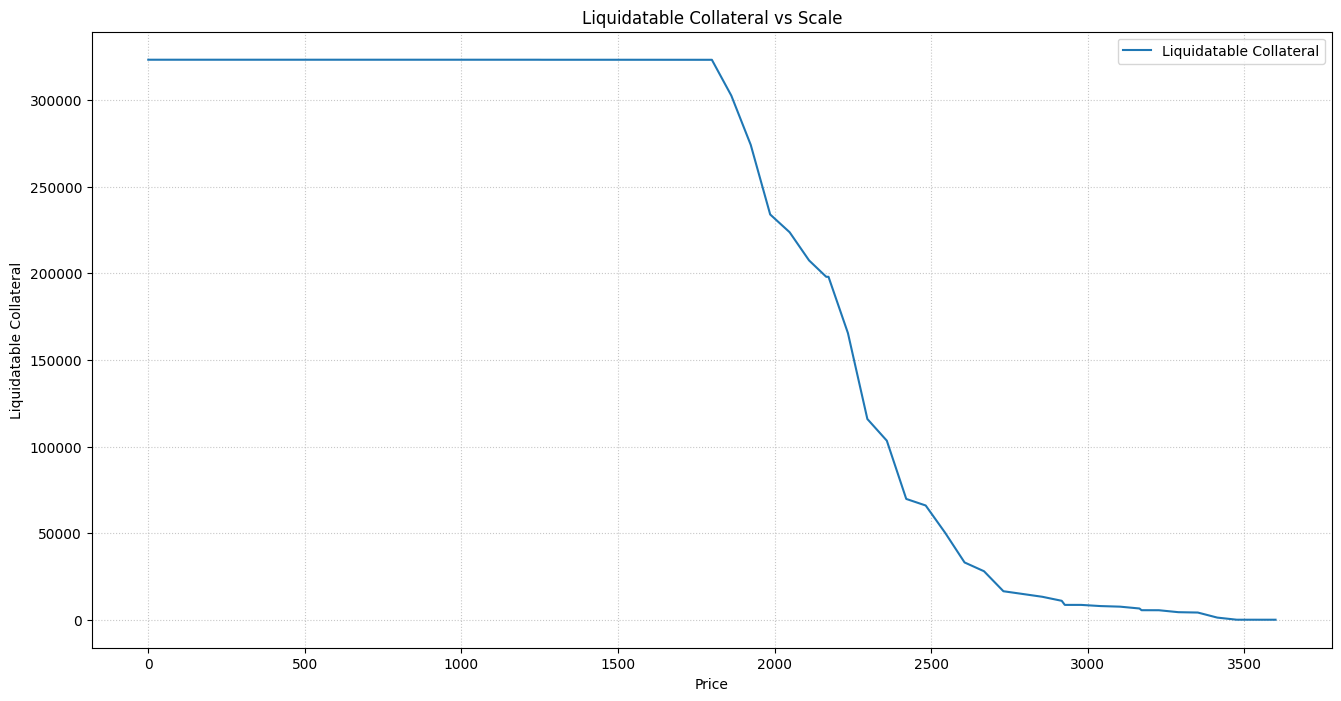

In [105]:
# plot scale and liquidatable_collateral
plt.figure(figsize=(16, 8))
plt.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], label='Liquidatable Collateral')
plt.xlabel('Price')
plt.ylabel('Liquidatable Collateral')
plt.title('Liquidatable Collateral vs Scale')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

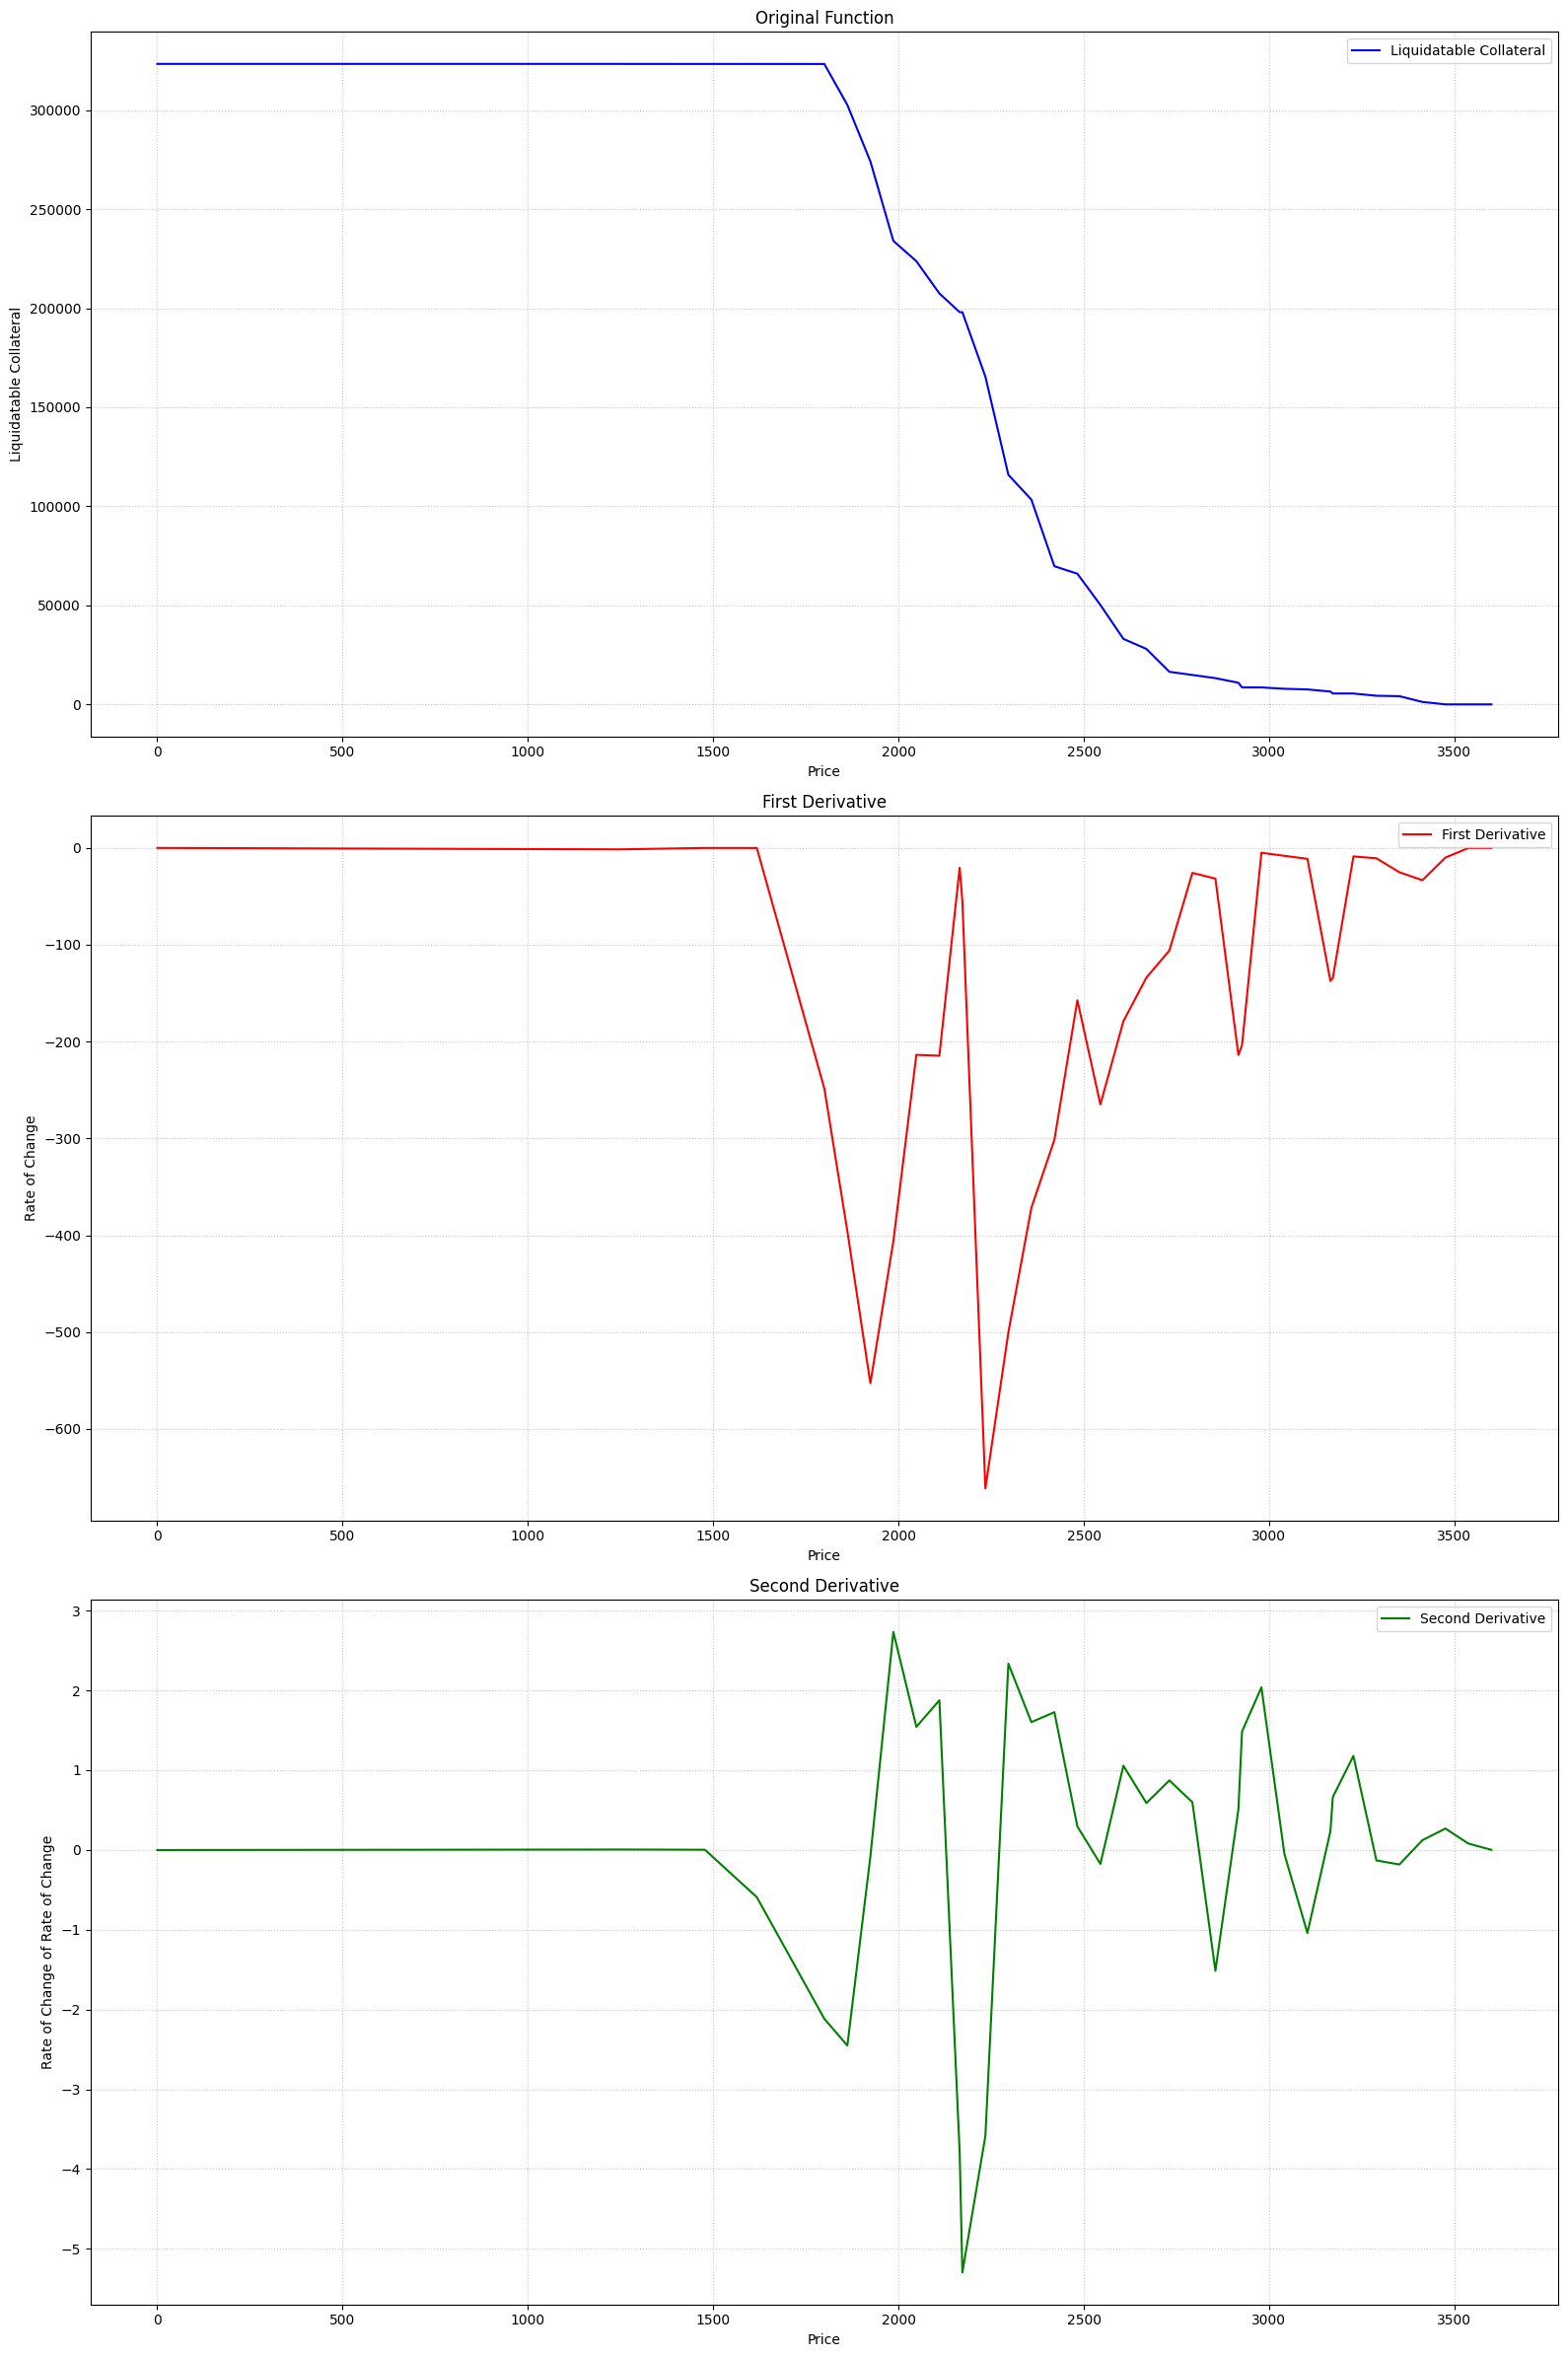

In [106]:
import numpy as np

# Calculate first and second derivatives
first_derivative = np.gradient(combined_df['cumulative_liquidatable_collateral'], combined_df['price'])
second_derivative = np.gradient(first_derivative, combined_df['price'])

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 24))

# Plot original function
ax1.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], 'b-', label='Liquidatable Collateral')
ax1.set_xlabel('Price')
ax1.set_ylabel('Liquidatable Collateral')
ax1.set_title('Original Function')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# Plot first derivative
ax2.plot(combined_df['price'], first_derivative, 'r-', label='First Derivative')
ax2.set_xlabel('Price')
ax2.set_ylabel('Rate of Change')
ax2.set_title('First Derivative')
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

# Plot second derivative
ax3.plot(combined_df['price'], second_derivative, 'g-', label='Second Derivative')
ax3.set_xlabel('Price')
ax3.set_ylabel('Rate of Change of Rate of Change')
ax3.set_title('Second Derivative')
ax3.grid(True, linestyle=':', alpha=0.7)
ax3.legend()

plt.tight_layout()
plt.show()

---

In [107]:
# Find value from aave_asset_object_dict where the key is the same as ASSET_UNDER_CONSIDERATION
asset_object = next((value for key, value in aave_asset_object_dict.items() if key == ASSET_UNDER_CONSIDERATION), None)


In [108]:
PRICE_ASSUMPTION = 0.85*asset_object.price


In [128]:
PRICE_ASSUMPTION

3059.9235

In [109]:
def get_curve_liquidation_data(output_liq_df: pd.DataFrame, price_assumption: float) -> tuple[float, float]:
    """
    Get curve liquidation data for the closest price point >= price_assumption.
    Returns (collateral, debt) tuple or (None, None) if no suitable price found.
    """
    # Check if there are any prices >= price_assumption
    valid_rows = output_liq_df[output_liq_df['max_price'] <= price_assumption]
    
    if valid_rows.empty:
        return None, None
    
    # Get the closest row
    closest_row = valid_rows.sort_values('max_price').iloc[-1]
    return {ASSET_UNDER_CONSIDERATION_CURVE:float(closest_row['max_collateral_value'])}, {'crvUSD':float(closest_row['debt'])}


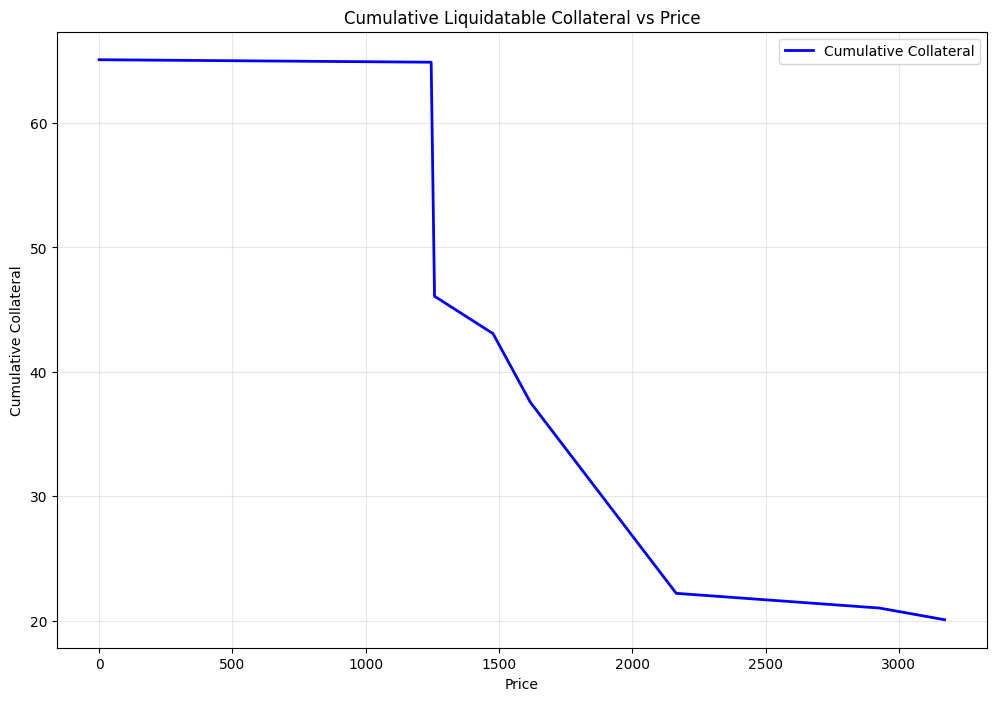

In [110]:
# Create a copy and sort by max_price in descending order
plot_df = output_liq_df.copy()
plot_df = plot_df.sort_values('max_price', ascending=False)

# Add cumulative sum column
plot_df['cum_collateral'] = plot_df['max_collateral_value'].cumsum()

plot_df['cum_debt'] = plot_df['debt'].cumsum()

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(plot_df['max_price'], plot_df['cum_collateral'], 
         label='Cumulative Collateral', 
         color='blue',
         linewidth=2)

plt.xlabel('Price')
plt.ylabel('Cumulative Collateral')
plt.title('Cumulative Liquidatable Collateral vs Price')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [111]:
curve_collateral, curve_debt = get_curve_liquidation_data(output_liq_df, PRICE_ASSUMPTION)

In [112]:
def analyze_liquidatable_positions(
    aave_supported_asset_data: pd.DataFrame,
    aave_user_position_data: pd.DataFrame,
    asset_under_consideration: str,
    price_assumption: float,
    emode_lt: float,
    min_usd_threshold: float = 15000
) -> dict:
    """
    Analyzes liquidatable positions for given asset and price assumption.
    Returns both raw and USD values for liquidatable collateral and debt.
    """
    # Create price mapping
    new_price_mapping = {asset_under_consideration: price_assumption}
    price_mapping = dict(zip(aave_supported_asset_data['symbol'], aave_supported_asset_data['price']))
    
    # Create asset mapping and get health ratios
    asset_mapping = create_asset_mapping(aave_supported_asset_data, new_price_mapping)
    
    # Get health ratio data for both normal and emode
    health_ratio_data_no_emode = create_health_ratio_data(aave_user_position_data, asset_mapping)
    health_ratio_data_emode = create_health_ratio_data_emode(aave_user_position_data, asset_mapping, emode_lt)
    health_ratio_data = pd.concat([health_ratio_data_no_emode, health_ratio_data_emode])
    
    # Get liquidatable positions
    total_liquidatable_collateral, total_liquidatable_debt = create_liquidatable_user_data(health_ratio_data)
    
    # Filter non-zero positions
    total_liquidatable_collateral = {k: v for k, v in total_liquidatable_collateral.items() if v > 0}
    total_liquidatable_debt = {k: v for k, v in total_liquidatable_debt.items() if v > 0}
    
    # Convert to USD
    total_liquidatable_collateral_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_collateral.items()
    }
    
    total_liquidatable_debt_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_debt.items()
    }
    
    # Filter by USD threshold
    filtered_collateral_usd = {k: v for k, v in total_liquidatable_collateral_usd.items() if v > min_usd_threshold}
    filtered_debt_usd = {k: v for k, v in total_liquidatable_debt_usd.items() if v > min_usd_threshold}
    
    # Reconstruct raw values from filtered USD values
    filtered_collateral = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_collateral_usd.items()
    }
    
    filtered_debt = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_debt_usd.items()
    }
    
    return filtered_collateral, filtered_debt

In [113]:
aave_collateral, aave_debt = analyze_liquidatable_positions(
    aave_supported_asset_data,
    aave_user_position_data,
    ASSET_UNDER_CONSIDERATION,
    PRICE_ASSUMPTION,
    AAVE_EMODE_LT
)

aave_collateral

{'WETH': 7748.708676917095,
 'wstETH': 6.57618537289123,
 'WBTC': 13.55443767,
 'AAVE': 605.7608362897674,
 'ETHx': 9.621399850846554}

In [114]:
def merge_liquidation_data(aave_data: dict, curve_data: dict) -> dict:
    """
    Merge liquidation data from Aave and Curve protocols.
    """
    merged_data = aave_data.copy()  # Start with Aave data
    
    # Merge Curve data
    for token, amount in curve_data.items():
        if token in merged_data:
            merged_data[token] += amount
        else:
            merged_data[token] = amount
    
    return merged_data


In [115]:
# Merge collateral data
total_collateral = merge_liquidation_data(aave_collateral, curve_collateral)

# Merge debt data
total_debt = merge_liquidation_data(aave_debt, curve_debt)

print("Total Liquidatable Collateral:")
print(json.dumps(total_collateral, indent=4))
print("\nTotal Liquidatable Debt:")
print(json.dumps(total_debt, indent=4))

Total Liquidatable Collateral:
{
    "WETH": 7749.6490523513885,
    "wstETH": 6.57618537289123,
    "WBTC": 13.55443767,
    "AAVE": 605.7608362897674,
    "ETHx": 9.621399850846554
}

Total Liquidatable Debt:
{
    "WETH": 9.369214259821442,
    "wstETH": 1887.1996703294296,
    "WBTC": 0.22381784,
    "USDC": 2671619.258961,
    "cbETH": 236.1577270885336,
    "USDT": 8735503.661896002,
    "rETH": 247.2120344396576,
    "GHO": 16240.859328298819,
    "RPL": 2266.3523831794855,
    "weETH": 932.1435032457356,
    "osETH": 9.52752104757144,
    "crvUSD": 6404.185700295031
}


In [116]:
import pickle
import os

# Try to load existing trade_pair_hashmap or create new one
try:
    if os.path.exists('trade_pair_hashmap.pkl'):
        with open('trade_pair_hashmap.pkl', 'rb') as f:
            trade_pair_hashmap = pickle.load(f)
        print(f"Loaded existing trade_pair_hashmap with {len(trade_pair_hashmap)} pairs")
    else:
        trade_pair_hashmap = {}
        print("Created new empty trade_pair_hashmap")
except Exception as e:
    print(f"Error loading trade_pair_hashmap: {str(e)}")
    trade_pair_hashmap = {}
    print("Created new empty trade_pair_hashmap due to error")

Loaded existing trade_pair_hashmap with 78 pairs


In [117]:
# FLASHLOAN_ASSET_SYMBOLS = ['WETH']
FLASHLOAN_ASSET_SYMBOLS = ['USDC', 'USDT', 'DAI', 'WETH']


from itertools import product
from tqdm import tqdm

# Create sets for easier lookup
flashloan_assets = set(FLASHLOAN_ASSET_SYMBOLS)
liquidatable_debt_assets = set(total_debt.keys())
liquidatable_collateral_assets = set(total_collateral.keys())

# Function to create and store PairDTO if it doesn't exist
def create_and_store_pair(sell_token, buy_token, trade_pair_hashmap):
    if sell_token != buy_token:
        key = f"{sell_token}-{buy_token}"
        if key not in trade_pair_hashmap:
            
            print(f"Creating pair: {sell_token} -> {buy_token}")
            
            pair_dto = PairDTO(
                sell_token=aave_asset_object_dict[sell_token],
                buy_token=aave_asset_object_dict[buy_token],
                network=ETHEREUM_DTO
            )
            trade_pair_hashmap[key] = pair_dto
            return 1
    return 0

# Set 1: Flashloan assets as sell, liquidatable debt as buy
new_pairs_count = 0
total_pairs_set1 = len(flashloan_assets) * len(liquidatable_debt_assets)
for sell_token, buy_token in tqdm(product(flashloan_assets, liquidatable_debt_assets), 
                                  total=total_pairs_set1, 
                                  desc="Creating Set 1 PairDTO objects"):
    new_pairs_count += create_and_store_pair(sell_token, buy_token, trade_pair_hashmap)

# Set 2: Liquidatable collateral as sell, flashloan assets as buy
total_pairs_set2 = len(liquidatable_collateral_assets) * len(flashloan_assets)
for sell_token, buy_token in tqdm(product(liquidatable_collateral_assets, flashloan_assets), 
                                  total=total_pairs_set2, 
                                  desc="Creating Set 2 PairDTO objects"):
    new_pairs_count += create_and_store_pair(sell_token, buy_token, trade_pair_hashmap)

print(f"Total pairs in trade_pair_hashmap: {len(trade_pair_hashmap)}")
print(f"New pairs added: {new_pairs_count}")

# Save updated trade_pair_hashmap to a pickle file
import pickle
with open('trade_pair_hashmap.pkl', 'wb') as f:
    pickle.dump(trade_pair_hashmap, f)

Creating Set 2 PairDTO objects: 100%|██████████| 20/20 [00:00<?, ?it/s]

Total pairs in trade_pair_hashmap: 78
New pairs added: 0


C:\Users\dhruv\AppData\Local\Temp\ipykernel_42840\3219523454.py:25: RuntimeWarning: overflow encountered in exp
  y = (x * r) * (1 - (1/np.exp(exponent)))


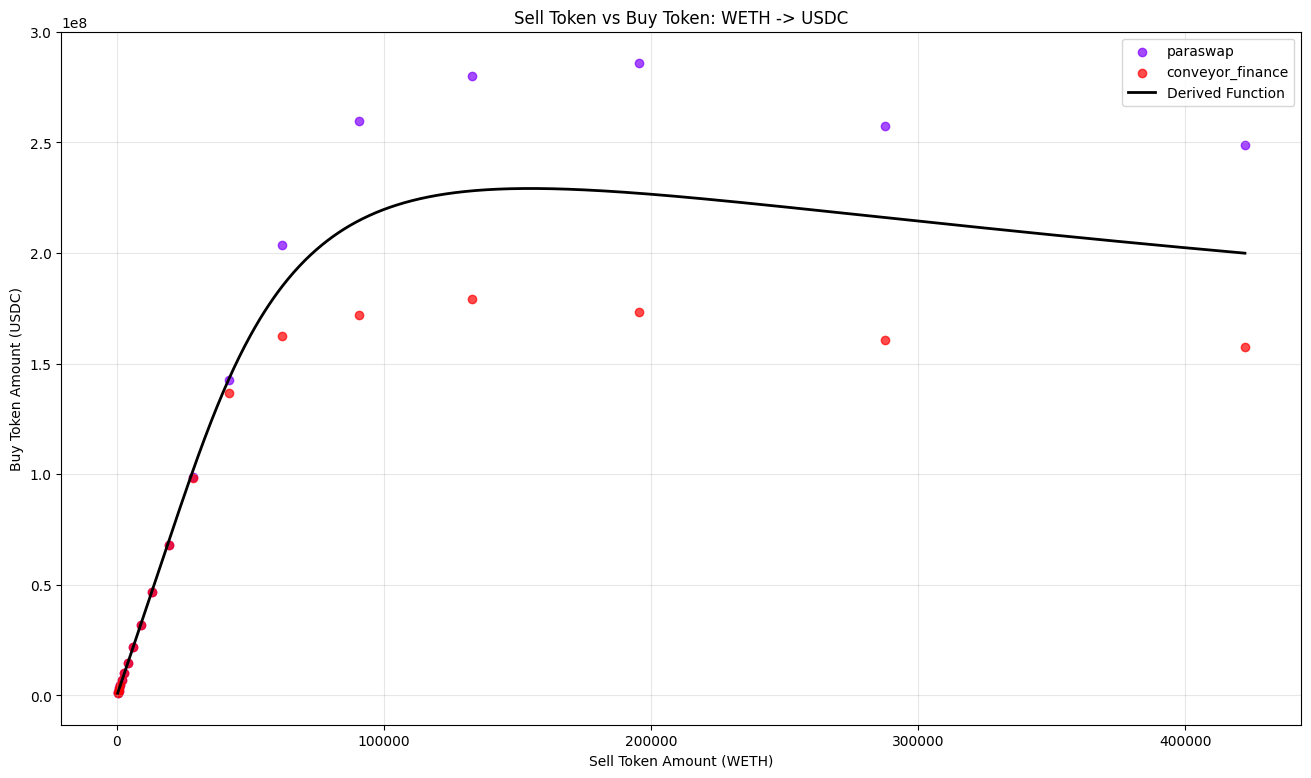


Function parameters:
Exchange Price (r): 3596.313686
k: 3724289.422253
c: 1.319206


In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Creata a copy of updated_trade_pair_hashmap
updated_trade_pair_hashmap_copy = trade_pair_hashmap.copy()


pair = updated_trade_pair_hashmap_copy["WETH-USDC"]


def derived_func(x, r, k, c):
    """
    Calculate the value of y based on the given formula.

    Parameters:
        x (float): The value of x in the formula.
        r (float): The value of r in the formula.
        k (float): The value of k in the formula.
        c (float): The value of c in the formula.

    Returns:
        float: The calculated value of y.
    """
    exponent = k * (x ** -c)
    y = (x * r) * (1 - (1/np.exp(exponent)))
    return y

r = pair.exchange_price
k = pair.k
c = pair.c

pair_quotes_df = pair.quotes_df

# Create a new figure with a larger size
plt.figure(figsize=(16, 9))

# Plot scatter points for each dex_aggregator
aggregators = pair_quotes_df['dex_aggregator'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(aggregators)))

sell_token_decimals = pair.sell_token.decimals
buy_token_decimals = pair.buy_token.decimals

for aggregator, color in zip(aggregators, colors):
    df_agg = pair_quotes_df[pair_quotes_df['dex_aggregator'] == aggregator]
    if not df_agg.empty:
        adjusted_sell_amount = df_agg['sell_token_amount'] / (10 ** sell_token_decimals)
        adjusted_buy_amount = df_agg['buy_token_amount'] / (10 ** buy_token_decimals)
        plt.scatter(adjusted_sell_amount, 
                    adjusted_buy_amount, 
                    label=aggregator, color=color, alpha=0.7)
    else:
        print(f"No data for aggregator: {aggregator}")

# Plot the derived function
if not pair_quotes_df.empty:
    x_min = pair_quotes_df['sell_token_amount'].min() / (10 ** sell_token_decimals)
    x_max = pair_quotes_df['sell_token_amount'].max() / (10 ** sell_token_decimals)
    x_range = np.linspace(x_min, x_max, 1000)
    y_derived = derived_func(x_range, r, k, c)
    plt.plot(x_range, y_derived, 'k-', label='Derived Function', linewidth=2)

plt.xlabel(f'Sell Token Amount ({pair.sell_token.symbol})')
plt.ylabel(f'Buy Token Amount ({pair.buy_token.symbol})')
plt.title(f'Sell Token vs Buy Token: {pair.sell_token.symbol} -> {pair.buy_token.symbol}')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

# Print the function parameters
print(f"\nFunction parameters:")
print(f"Exchange Price (r): {r:.6f}")
print(f"k: {k:.6f}")
print(f"c: {c:.6f}")

In [119]:
# Create price mapping
new_price_mapping = {ASSET_UNDER_CONSIDERATION: PRICE_ASSUMPTION}
price_mapping = dict(zip(aave_supported_asset_data['symbol'], aave_supported_asset_data['price']))

# Create asset mapping and get health ratios
asset_mapping = create_asset_mapping(aave_supported_asset_data, new_price_mapping)

In [120]:
asset_mapping

{'WETH': {'price': 3059.9235, 'liquidationThreshold': 0.83},
 'wstETH': {'price': 4265.52, 'liquidationThreshold': 0.81},
 'WBTC': {'price': 97229.0, 'liquidationThreshold': 0.78},
 'USDC': {'price': 1.001, 'liquidationThreshold': 0.78},
 'DAI': {'price': 1.0, 'liquidationThreshold': 0.77},
 'LINK': {'price': 18.35, 'liquidationThreshold': 0.71},
 'AAVE': {'price': 199.67, 'liquidationThreshold': 0.73},
 'cbETH': {'price': 3900.06, 'liquidationThreshold': 0.79},
 'USDT': {'price': 1.001, 'liquidationThreshold': 0.78},
 'rETH': {'price': 4006.63, 'liquidationThreshold': 0.79},
 'LUSD': {'price': 0.99721, 'liquidationThreshold': 0.77},
 'CRV': {'price': 0.53855, 'liquidationThreshold': 0.41},
 'MKR': {'price': 1812.23, 'liquidationThreshold': 0.7},
 'SNX': {'price': 2.39, 'liquidationThreshold': 0.65},
 'BAL': {'price': 2.81, 'liquidationThreshold': 0.59},
 'UNI': {'price': 12.68, 'liquidationThreshold': 0.74},
 'LDO': {'price': 1.76, 'liquidationThreshold': 0.5},
 'ENS': {'price': 32.98

In [121]:
def construct_new_price_mapping(asset_mapping, 
                                new_price_mapping,
                                total_liquidatable_collateral,
                                total_liquidatable_debt):
    
    output_mapping = {}
    
    # Extract keys from total_liquidatable_collateral and total_liquidatable_debt and add to separate sets
    liquidatable_collateral_assets = set(total_liquidatable_collateral.keys())
    liquidatable_debt_assets = set(total_liquidatable_debt.keys())
    
    # Join liquidatable_collateral_assets and liquidatable_debt_assets and remove duplicates
    liquidatable_assets = liquidatable_collateral_assets.union(liquidatable_debt_assets)    
    
    for asset in liquidatable_assets:
        if asset in new_price_mapping:
            price = new_price_mapping[asset]
            
            output_mapping[asset] = price
        else:
            price = asset_mapping[asset]['price']
            output_mapping[asset] = price
    
    for asset in FLASHLOAN_ASSET_SYMBOLS:
        price = asset_mapping[asset]['price']
        output_mapping[asset] = price
            
    return output_mapping



In [122]:
new_broad_price_mapping = construct_new_price_mapping(asset_mapping, new_price_mapping, total_collateral, total_debt)


In [123]:
updated_trade_pair_hashmap = update_trade_pair_exchange_price(trade_pair_hashmap, new_broad_price_mapping)


In [124]:
liquidation_profits_df = scale_supply_and_create_liquidations(updated_trade_pair_hashmap, 
                                                              asset_mapping, 
                                                              total_collateral, 
                                                              total_debt,
                                                              0.02, 
                                                              2, 
                                                              80)


{'flashloan_asset': 'WETH', 'flashloan_asset_price': 3059.9235, 'flashloan_start': np.float64(154.90135856506143), 'flashloan_start_usd': np.float64(473986.30725515774), 'flashloan_end': np.float64(164.81720517913627), 'flashloan_end_usd': np.float64(504328.0393319607), 'flashloan_profit': np.float64(30341.732076803026), 'flashloan_profit_usd': np.float64(92843379.01251338)}
{'flashloan_asset': 'WETH', 'flashloan_asset_price': 3059.9235, 'flashloan_start': np.float64(361.77848730737145), 'flashloan_start_usd': np.float64(1107014.4951062775), 'flashloan_end': np.float64(371.36028508716777), 'flashloan_end_usd': np.float64(1136334.0633049242), 'flashloan_profit': np.float64(29319.56819864658), 'flashloan_profit_usd': np.float64(89715635.74089134)}
{'flashloan_asset': 'WETH', 'flashloan_asset_price': 3059.9235, 'flashloan_start': np.float64(568.940073608416), 'flashloan_start_usd': np.float64(1740913.101326122), 'flashloan_end': np.float64(577.9033649951992), 'flashloan_end_usd': np.float

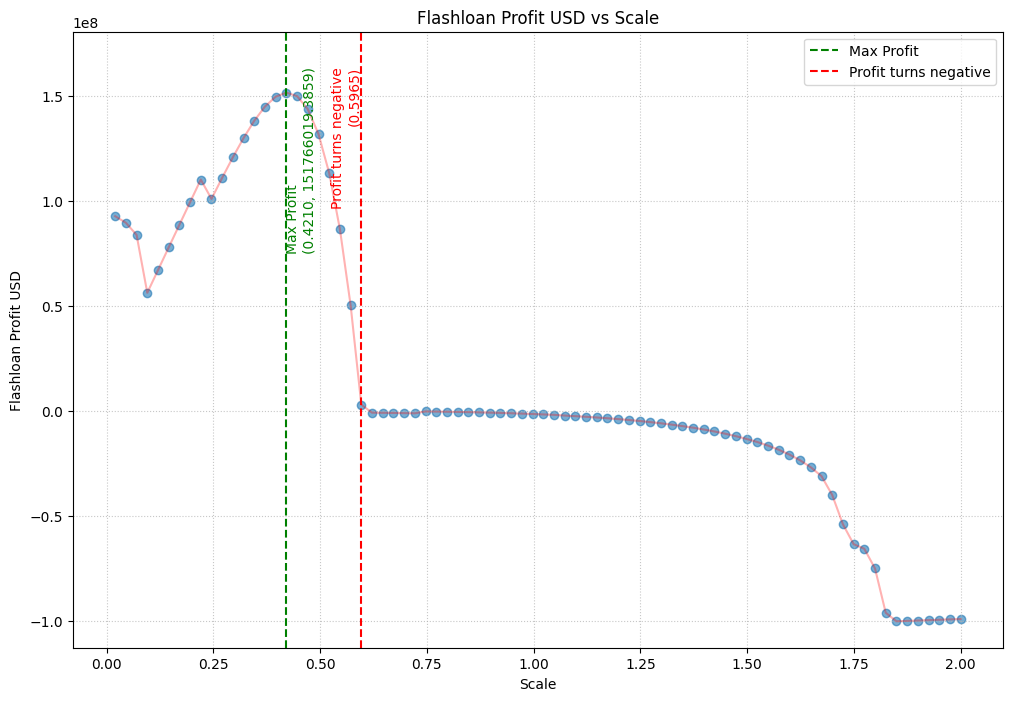

Maximum profit point: Scale = 0.42, Profit = 151766019.39
Profit turns negative at: Scale = 0.60


In [125]:
# Sort the dataframe by scale
sorted_df = liquidation_profits_df.sort_values('scale')

# Find the point of maximum profit
max_profit_idx = sorted_df['flashloan_profit_usd'].idxmax()
max_profit_x = sorted_df.loc[max_profit_idx, 'scale']
max_profit_y = sorted_df.loc[max_profit_idx, 'flashloan_profit_usd']

# Find the point where profit turns negative
positive_profits = sorted_df[sorted_df['flashloan_profit_usd'] > 0]
if not positive_profits.empty:
    last_positive_idx = positive_profits.index[-1]
    zero_crossing_x = sorted_df.loc[last_positive_idx, 'scale']
    zero_crossing_y = 0
else:
    zero_crossing_x = zero_crossing_y = None

# Create the plot
plt.figure(figsize=(12, 8))
plt.scatter(sorted_df['scale'], sorted_df['flashloan_profit_usd'], alpha=0.6)
plt.plot(sorted_df['scale'], sorted_df['flashloan_profit_usd'], 'r-', alpha=0.3)

# Add vertical lines and annotations
plt.axvline(x=max_profit_x, color='g', linestyle='--', label='Max Profit')
plt.text(max_profit_x, plt.ylim()[1], f'Max Profit\n({max_profit_x:.4f}, {max_profit_y:.4f})', 
         rotation=90, va='top', ha='left', color='g')

if zero_crossing_x:
    plt.axvline(x=zero_crossing_x, color='r', linestyle='--', label='Profit turns negative')
    plt.text(zero_crossing_x, plt.ylim()[1], f'Profit turns negative\n({zero_crossing_x:.4f})', 
             rotation=90, va='top', ha='right', color='r')

# Adjust y-axis to give more space for labels
plt.ylim(plt.ylim()[0], plt.ylim()[1] * 1.1)

plt.xlabel('Scale')
plt.ylabel('Flashloan Profit USD')
plt.title('Flashloan Profit USD vs Scale')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Use scientific notation for y-axis if numbers are very large
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.tight_layout()
plt.show()

# Print the exact values
print(f"Maximum profit point: Scale = {max_profit_x:.2f}, Profit = {max_profit_y:.2f}")
if zero_crossing_x:
    print(f"Profit turns negative at: Scale = {zero_crossing_x:.2f}")
else:
    print("Profit does not turn negative within the given data range.")

---

In [126]:
import requests
from typing import Dict, Optional
import logging

def fetch_curve_market_data(
    network: str = "ethereum",
    page: int = 1,
    per_page: int = 10,
    fetch_on_chain: bool = False
) -> Optional[Dict]:
    """
    Fetch market data from Curve Finance API.
    
    Args:
        network (str): Network name (default: "ethereum")
        page (int): Page number for pagination (default: 1)
        per_page (int): Number of items per page (default: 10)
        fetch_on_chain (bool): Whether to fetch on-chain data (default: False)
        
    Returns:
        Optional[Dict]: JSON response from the API or None if request fails
    """
    
    base_url = "https://prices.curve.fi/v1/crvusd/markets"
    
    try:
        # Construct URL with query parameters
        url = f"{base_url}/{network}"
        params = {
            "fetch_on_chain": str(fetch_on_chain).lower(),
            "page": page,
            "per_page": per_page
        }
        
        # Make the request
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()  # Raise exception for non-200 status codes
        
        return response.json()['data']
        
    except requests.RequestException as e:
        logging.error(f"Error fetching Curve market data: {str(e)}")
        return None

In [127]:
# Example usage
market_data = fetch_curve_market_data(
    network="ethereum",
    page=1,
    per_page=10,
    fetch_on_chain=False
)

if market_data:
    print(json.dumps(market_data, indent=4))
else:
    print("Failed to fetch market data")

[
    {
        "address": "0x8472A9A7632b173c8Cf3a86D3afec50c35548e76",
        "factory_address": "0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC",
        "llamma": "0x136e783846ef68C8Bd00a3369F787dF8d683a696",
        "rate": 0.1732388227788837,
        "total_debt": 187649.52191816608,
        "n_loans": 11,
        "debt_ceiling": null,
        "borrowable": 0.0,
        "pending_fees": 13576.08058674766,
        "collected_fees": 172190.9307192066,
        "collateral_amount": 158.6927431286274,
        "collateral_amount_usd": 644380.6681182608,
        "stablecoin_amount": 0.0,
        "collateral_token": {
            "symbol": "sfrxETH",
            "address": "0xac3E018457B222d93114458476f3E3416Abbe38F"
        },
        "stablecoin_token": {
            "symbol": "crvUSD",
            "address": "0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E"
        }
    },
    {
        "address": "0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE",
        "factory_address": "0xC9332fdCB1C491Dcc683